In [1]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    competition = 'titanic'
    path = Path(f'/root/{competition}')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(competition, path=path)
        zipfile.ZipFile(f'{path}/titanic.zip').extractall(path)

100%|██████████| 34.1k/34.1k [00:00<00:00, 1.39MB/s]

In [2]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

In [3]:
!ls {path}

gender_submission.csv  test.csv  titanic.zip  train.csv


In [4]:
train_df = pd.read_csv(path/'train.csv')

In [5]:
train_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


### Missing data

In [6]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
modes = train_df.mode().loc[0]

In [8]:
train_df.fillna(modes, inplace=True)

In [9]:
train_df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [10]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
train_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [12]:
train_df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [13]:
train_df.groupby(['Pclass'])['Survived'].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [14]:
train_df['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [15]:
train_df.groupby(['SibSp'])['Survived'].mean()

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

In [16]:
train_df['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [17]:
train_df.groupby(['Parch'])['Survived'].mean()

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64

<AxesSubplot:>

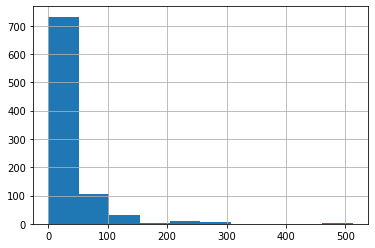

In [18]:
train_df['Fare'].hist()

<AxesSubplot:>

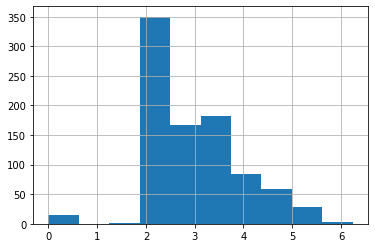

In [19]:
np.log(train_df['Fare'] + 1).hist()

In [20]:
train_df['LogFare'] = np.log(train_df['Fare'] + 1)

In [21]:
train_df.describe(include=object)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [22]:
train_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [23]:
train_df['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [24]:
train_df['Cabin'].value_counts()

B96 B98        691
G6               4
C23 C25 C27      4
C22 C26          3
F33              3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 147, dtype: int64

In [25]:
train_df['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

### Encodings

In [26]:
dummy_columns = ['Sex', 'Pclass', 'Embarked']
expanded_dummy_cols = list(pd.get_dummies(train_df[dummy_columns], columns=dummy_columns).columns)

In [27]:
expanded_dummy_cols

['Sex_female',
 'Sex_male',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S']

In [28]:
train_df = pd.get_dummies(train_df, columns=dummy_columns)

### Create tensors from data

In [131]:
Y = torch.tensor(train_df['Survived'].values, dtype=torch.float)

In [132]:
Y.shape

torch.Size([891])

### this unsqueeze operation here is extremely important, to make sure broadcasting works as expected during computation of the loss. Without it, nothing will error out, but the model will not train properly --> both AK and JH have warned for this, always make sure you fully understand whats going on and debug these broadcasting operations

In [133]:
Y = Y.unsqueeze(-1)

In [134]:
Y.shape

torch.Size([891, 1])

In [135]:
Y[:3,:]

tensor([[0.],
        [1.],
        [1.]])

In [136]:
train_df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [137]:
train_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + expanded_dummy_cols

X = torch.tensor(train_df[train_cols].values, dtype=torch.float)

In [138]:
X.shape

torch.Size([891, 12])

In [139]:
X[:3,:]

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000]])

### Let's do a forward pass of a very simple linear model without activations

In [140]:
torch.manual_seed(442)

coeffs = torch.rand(size=(X.shape[1], 1))
coeffs.shape

torch.Size([12, 1])

In [141]:
#  [891, 12] @ [12, 1] --> [891, 1]
preds = X @ coeffs
preds.shape

torch.Size([891, 1])

In [142]:
loss = torch.abs(Y - preds).mean()
loss.item()

3.842719793319702

In [143]:
preds.mean()

tensor(4.2266)

This seems to work, however the average prediction is super high. We expect something in the range of (0,1)

So let's have a look at normalization and initialisation of the coeffs

In [144]:
dict(zip(train_cols, X.mean(dim=0)))

{'Age': tensor(28.5670),
 'SibSp': tensor(0.5230),
 'Parch': tensor(0.3816),
 'LogFare': tensor(2.9622),
 'Sex_female': tensor(0.3524),
 'Sex_male': tensor(0.6476),
 'Pclass_1': tensor(0.2424),
 'Pclass_2': tensor(0.2065),
 'Pclass_3': tensor(0.5511),
 'Embarked_C': tensor(0.1886),
 'Embarked_Q': tensor(0.0864),
 'Embarked_S': tensor(0.7250)}

Especially `Age` is very large, let's normalize by dividing through the max value per column

In [145]:
max_vals, max_idxs = X.max(dim=0)

In [146]:
max_vals.shape

torch.Size([12])

In [147]:
# [891, 12]
# [12] --> [1,12] --> [891, 12]
(X / max_vals).shape

torch.Size([891, 12])

In [148]:
X = X / max_vals

In [149]:
X.max(dim=0)[0] #this should all be ones

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

And let's do again the forward pass

In [150]:
preds = X @ coeffs
loss = torch.abs(Y - preds).mean()
loss

tensor(1.5871)

Much better!

Let's also tweak initialisation, currently we draw from a uniform distribution between 0 and 1, so let's center around 0 by subtracting 0.5

In [151]:
torch.manual_seed(442)

coeffs = torch.rand(size=(X.shape[1], 1))-0.5

In [152]:
preds = X @ coeffs
loss = torch.abs(Y - preds).mean()
loss

tensor(0.5200)

Much much better!

### Now let's formalize and train this for a couple of epochs

In [259]:
def init_coeffs(): 
    torch.manual_seed(442)
    return (torch.rand(size=(X.shape[1], 1))-0.5).requires_grad_()

def get_preds(X, coeffs): return X @ coeffs

def get_loss(Y, preds): return torch.abs(Y - preds).mean()

def forward(X, Y, coeffs):
    preds = get_preds(X, coeffs)
    loss = get_loss(Y, preds)
    return loss

def train(epochs=20, lr=0.01):
    coeffs = init_coeffs()
    for _ in range(epochs):
        loss = forward(X, Y, coeffs)
        loss.backward()
        with torch.no_grad():
            coeffs -= coeffs.grad * 0.2
            coeffs.grad.zero_()
        print(f'{loss:.4f}')
    return coeffs

In [260]:
coeffs = train(18,0.2)

0.5200
0.4922
0.4686
0.4451
0.4218
0.3997
0.3781
0.3574
0.3403
0.3368
0.3245
0.3314
0.3043
0.3128
0.2973
0.2969
0.2893
0.2862


### Let's add a metric: accuracy

In [261]:
forward(X, Y, coeffs)

tensor(0.2828, grad_fn=<MeanBackward0>)

In [262]:
(Y.bool() == (get_preds(X, coeffs) > 0.5)).float().mean()

tensor(0.7868)

In [263]:
def acc(x, y): return (y.bool() == (get_preds(x, coeffs) > 0.5)).float().mean()

But since we only compute the metrics on the validation set, we will also have to implement a split

In [264]:
from sklearn.model_selection import train_test_split

In [265]:
out = train_test_split(X, Y, test_size=0.2)
[o.shape for o in out]

[torch.Size([712, 12]),
 torch.Size([179, 12]),
 torch.Size([712, 1]),
 torch.Size([179, 1])]

In [266]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

In [267]:
def train(epochs=20, lr=0.01):
    coeffs = init_coeffs()
    for _ in range(epochs):
        loss = forward(X_train, Y_train, coeffs)
        loss.backward()
        with torch.no_grad():
            coeffs -= coeffs.grad * lr
            coeffs.grad.zero_()
        print(f'{loss:.4f}')        
    return coeffs

In [268]:
coeffs = train(18, 0.2)

0.5190
0.4900
0.4658
0.4418
0.4182
0.3965
0.3838
0.3593
0.3620
0.3218
0.3112
0.3186
0.3087
0.3125
0.2931
0.2937
0.2899
0.2858


In [269]:
(Y_val.bool() == (get_preds(X_val, coeffs) > 0.5)).float().mean()

tensor(0.7765)

In [270]:
acc(X_val, Y_val)

tensor(0.7765)

Let's add a sigmoid as well

In [271]:
def get_preds(X, coeffs): return torch.sigmoid(X @ coeffs)

In [272]:
coeffs = train(18, 100)

0.5054
0.3209
0.2553
0.2042
0.2017
0.2004
0.1995
0.1989
0.1984
0.1981
0.1978
0.1976
0.1975
0.1973
0.1972
0.1971
0.1970
0.1970


In [273]:
acc(X_val, Y_val)

tensor(0.8380)

#### Now let's submit to kaggle

In [293]:
test_df = pd.read_csv(path/'test.csv')

# We need to replicate the preprocessing pipeline:

test_df.fillna(modes, inplace=True)
test_df['LogFare'] = np.log(test_df['Fare']+1)
test_df = pd.get_dummies(test_df, columns=dummy_columns)

# Get X tensor
X_test = torch.tensor(test_df[train_cols].values, dtype=torch.float)

# Normalize:
X_test = X_test / max_vals

In [297]:
test_df['Survived'] = (get_preds(X_test, coeffs) > 0.5).int()

In [299]:
sub_df = test_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)